## 1. Import libraries

In [77]:
import numpy as np
import pandas as pd
import time

# machine learning library
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler


#import XGBOOST Libraries
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

# plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt

#Configure Panda
pd.options.display.width = 200

## 2. Loading and processing data
### 2.1 Load the files

In [2]:
# This is the input for our model

transactions_feb = pd.read_csv('data/transactions_feb.csv')
transactions_mar = pd.read_csv('data/transactions_mar_train_v2.csv')
transactions_apr = pd.read_csv('data/transactions_apr.csv')
members_feb = pd.read_csv('data/members_train1.csv')
members_mar = pd.read_csv('data/members_train2.csv')
members_apr = pd.read_csv('data/members_total.csv')
user_logs_feb = pd.read_csv('data/user_logs_feb.csv')
user_logs_mar = pd.read_csv('data/user_logs_mar.csv')
user_logs_apr = pd.read_csv('data/user_logs_apr.csv')

print('data loaded!')

data loaded!


##### Veryfying shape consistency before merging

In [4]:
print(user_logs_feb.shape)
print(user_logs_mar.shape)
print(user_logs_apr.shape)
print(members_feb.shape)
print(members_mar.shape)
print(members_apr.shape)
print(transactions_feb.shape)
print(transactions_mar.shape)
print(transactions_apr.shape)


(992931, 21)
(970960, 21)
(907471, 21)
(992931, 35)
(970960, 35)
(907471, 35)
(992931, 28)
(970960, 28)
(907471, 28)


##### Testing Zone: Creating copies for future feature manipulation

In [5]:
user_logs_feb_tweak = user_logs_feb.copy()
user_logs_mar_tweak = user_logs_mar.copy()
user_logs_apr_tweak = user_logs_apr.copy()

### 2.2 Merge the different datasets

In this section, the different files containing the features are merged with the train and test data. Here, we need to have a look at the specifics of the problem we actually need to solve. We are given a training data set for february and march with the corresponding response variable "is_churn". We need to use this data and make a prediction for the month of april. To get an estimation of our performance, we are going to train the data on february and test it on march. For the month of april, we are going to train on the entire data, i.e. February and March. The prediction will then be made for april.

In [7]:
feb_data = pd.merge(members_feb,user_logs_feb.drop('is_churn',axis=1),on='msno')
feb_data = pd.merge(feb_data,transactions_mar.drop('is_churn',axis=1),on='msno')
mar_data = pd.merge(members_mar,user_logs_mar.drop('is_churn',axis=1),on='msno')
mar_data = pd.merge(mar_data,transactions_mar.drop('is_churn',axis=1),on='msno')
apr_data = pd.merge(members_apr,user_logs_apr.drop('is_churn',axis=1),on='msno')
apr_data = pd.merge(apr_data,transactions_apr.drop('is_churn',axis=1),on='msno')


##### Checking shapes

In [8]:
print(feb_data.shape)
print(mar_data.shape)
print(apr_data.shape)

(881701, 80)
(970960, 80)
(907471, 80)


### 2.4 Data cleaning

Let's make sure each dataset has the same order of its columns:

In [9]:
mar_data = mar_data[feb_data.columns]
apr_data = apr_data[mar_data.columns]


## 3. Algorithms
### 3.1 Logistic Regression

In [65]:
# Logistic Regression
def log_reg(train,test,final):
    if ('msno' in train.columns):
        train = train.drop('msno',axis=1)
    if ('msno' in test.columns):
        test = test.drop('msno',axis=1)
    X_train = train.drop('is_churn',axis=1)
    y_train = train['is_churn']
    X_test = test.drop('is_churn',axis=1)
    y_test = test['is_churn']

    model_log_reg = LogisticRegression(multi_class='multinomial',solver='newton-cg')
    model_log_reg.fit(X_train, y_train)
    y_pred_l = model_log_reg.predict(X_test)
    y_pred_l[y_pred_l<0] = 0
    y_pred_l[y_pred_l>0] = 1

    if (final == 1):
        return y_pred_l
    print("Logloss for Linear Regression is: %.6f"%log_loss(y_test,y_pred_l))
    #y_pred_l[y_pred_l>=0.95] = 1
    #y_pred_l[y_pred_l<0.05] = 0
    #print("(1 or 0) Logloss for Linear Regression is: %.6f"%log_loss(y_test,y_pred_l))



##### Veryfying model accurancy and over-fitting:

In [ ]:
lin_reg(feb_data,mar_data)
print('### over-fitting check: ###')
lin_reg(feb_data,feb_data)

### 3.2 Random Forrest

In [50]:
# Run Forest

def ran_for(train,test,importance,final):
    start = time.time()
    if ('msno' in train.columns):
        train = train.drop('msno',axis=1)
    if ('msno' in test.columns):
        test = test.drop('msno',axis=1)
    X_train = train.drop('is_churn',axis=1)
    y_train = train['is_churn']
    X_test = test.drop('is_churn',axis=1)
    y_test = test['is_churn']
    
    model_Forest = RandomForestRegressor()
    model_Forest.fit(X_train, y_train)
    y_pred_f = model_Forest.predict(X_test)
    
    if (final == 1):
        return y_pred_f
    
    print("Logloss for Random Forrest is: %.6f"%log_loss(y_test,y_pred_f))
    
    if (importance == 1):
        importances = model_Forest.feature_importances_
        indices = np.argsort(importances)[::-1]
        columns = np.array(list(X_train))
        return importances
        
        # Print the feature ranking
        print("\nFeature ranking:")
        
        for f in range(x_train.shape[1]):
            print("%d. %s (%f)" % (f + 1, columns[indices[f]], importances[indices[f]]))
    
    print('RF Time = %.0f'%(time.time() - start))


##### Veryfying model accurancy and over-fitting:

In [ ]:
ran_for(feb_data,mar_data,1)
print('### over-fitting check: ###')
ran_for(feb_data,feb_data,0)


### 3.3 XG Boost

In [85]:
# Run XGD Boost
def xgb_boost(train,test,importance,final):
    start = time.time()
    if ('msno' in train.columns):
        train = train.drop('msno',axis=1)
    if ('msno' in test.columns):
        test = test.drop('msno',axis=1)
    X_train = train.drop('is_churn',axis=1)
    y_train = train['is_churn']
    X_test = test.drop('is_churn',axis=1)
    y_test = test['is_churn']
    
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dtest = xgb.DMatrix(X_test, label = y_test)
    param = {
        'max_depth': 3,  # the maximum depth of each tree. Try with max_depth: 2 to 10.
        'eta': 0.3,  # the training step for each iteration. Try with ETA: 0.1, 0.2, 0.3...
        'silent': 1,  # logging mode - quiet
        'objective': 'multi:softprob',  # error evaluation for multiclass training
        'num_class': 10}  # the number of classes that exist in this datset
    num_round = 15  # the number of training iterations. Try with num_round around few hundred!
    #----------------
    bst = xgb.train(param, dtrain, num_round)
    y_pred_xgb = bst.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in y_pred_xgb])
    y_pred_xgb = y_pred_xgb[:,1] #Column 2 out of 3
    if (final == 1):
        return y_pred_xgb
    print("(probs) Logloss for XGD Boost is: %.6f"%log_loss(y_test,y_pred_xgb))
    
    if (importance == 1):
        xgb.plot_importance(bst)
        plt.show()
    
    #y_pred_xgb[y_pred_xgb>=0.5] = 1
    #y_pred_xgb[y_pred_xgb<0.5] = 0
    #print("(1 or 0) Logloss for XGD Boost is: %.6f"%log_loss(y_test,y_pred_xgb))

    print('XGB Time = %.0f'%(time.time() - start))
    
    return y_pred_xgb

##### Veryfying model accurancy and over-fitting:

In [ ]:
xgb_boost(feb_data,mar_data,1,0)
print('### over-fitting check: ###')
xgb_boost(feb_data,feb_data,0,0)

### 3.4 Neural Network

In [13]:
# Neural Network
def neural(train,test,cv):
    start = time.time()
    if ('msno' in train.columns):
        train = train.drop('msno',axis=1)
    if ('msno' in test.columns):
        test = test.drop('msno',axis=1)
    X_train = train.drop('is_churn',axis=1)
    y_train = train['is_churn']
    X_test = test.drop('is_churn',axis=1)
    y_test = test['is_churn']

    model_n = MLPClassifier()
    model_n.fit(X_train, y_train)
    y_pred_n = model_n.predict(X_test)
    
    print("Logloss for Neural Network is: %.6f"%log_loss(y_test,y_pred_n)) 
    
    if (cv == 1):
        cv = ShuffleSplit(n_splits=3, test_size=0.33, random_state=42)
        scores = cross_val_score(model_n, data_input, data_output, cv=cv, scoring='log_loss')
        #scores = - scores
        print(scores)
        print("CV log loss: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    print('Neural Time = %.0f'%(time.time() - start))

##### Veryfying model accurancy and over-fitting:

In [18]:
neural(feb_data,mar_data,0)
print('### over-fitting check: ###')
neural(feb_data,feb_data,0)

Logloss for Neural Network is: 3.355707
Neural Time = 172
### over-fitting check: ###
Logloss for Neural Network is: 0.938550
Neural Time = 28


### 3.5 Ada Boost

In [14]:
# AdaBoost
def ada_b(train,test,final):
    start = time.time()
    if ('msno' in train.columns):
        train = train.drop('msno',axis=1)
    if ('msno' in test.columns):
        test = test.drop('msno',axis=1)
    X_train = train.drop('is_churn',axis=1)
    y_train = train['is_churn']
    X_test = test.drop('is_churn',axis=1)
    y_test = test['is_churn']

    model_abr = AdaBoostRegressor()
    model_abr.fit(X_train, y_train)
    print('Model fitted!')
    y_pred_abr = model_abr.predict(X_test)
    if (final == 1):
        return y_pred_abr
    print("Logloss for AdaBoost is: %.6f"%log_loss(y_test,y_pred_abr))
    print('Time =',time.time() - start)

##### Veryfying model accurancy and over-fitting:

In [20]:
ada_b(feb_data,mar_data)
print('### over-fitting check: ###')
ada_b(feb_data,feb_data)

Model fitted!
Logloss for AdaBoost is: 0.280593
Time = 2894.4613180160522
### over-fitting check: ###
Model fitted!
Logloss for AdaBoost is: 0.164375
Time = 286.2973380088806


## 4. Feature Testing
### 4.1 Creating sample sets

We had to create relatively large sample sets (around 500k rows), as selecting fewer rows resulted in inconsistent results for feature removel between our tests and the final submission to Kaggle.

In [28]:
feb_sample = feb_data.sample(frac=0.5)
print(feb_sample.shape)

mar_sample = mar_data.sample(frac=0.5)
print(mar_sample.shape)

(440850, 80)
(485480, 80)


In [67]:
feb_sample.to_csv('feb_sample.csv', index=False)
mar_sample.to_csv('mar_sample.csv', index=False)

### 4.2 Removing individual features
As we already know that XG Boost is our most efficient algorithm, we only have to test the different feature constelations for XG Boost.

#### 4.2.1 Loop for removing every feature one-by-one

In [29]:
# columns selection
eng_columns = np.array(list(feb_sample.drop(columns=['is_churn','msno'],axis=1)))

for i in range(0,len(eng_columns)):
    inpt = eng_columns[i]
    data_input = feb_sample.drop(inpt,axis=1)
    data_outupt = mar_sample.drop(inpt,axis=1)
    print('\n###',inpt,'removed ###')
    #lin_reg(data_input,data_outupt)
    #ada_b(data_input,data_outupt,0)
    xgb_boost(data_input,data_outupt,0,0)


### city_1 removed ###
(probs) Logloss for XGD Boost is: 0.315704
XGB Time = 207

### city_3 removed ###
(probs) Logloss for XGD Boost is: 0.315704
XGB Time = 205

### city_4 removed ###
(probs) Logloss for XGD Boost is: 0.315704
XGB Time = 203

### city_5 removed ###
(probs) Logloss for XGD Boost is: 0.315704
XGB Time = 199

### city_6 removed ###
(probs) Logloss for XGD Boost is: 0.315704
XGB Time = 199

### city_7 removed ###
(probs) Logloss for XGD Boost is: 0.315704
XGB Time = 198

### city_8 removed ###
(probs) Logloss for XGD Boost is: 0.315704
XGB Time = 202

### city_9 removed ###
(probs) Logloss for XGD Boost is: 0.315704
XGB Time = 202

### city_10 removed ###
(probs) Logloss for XGD Boost is: 0.315704
XGB Time = 203

### city_11 removed ###
(probs) Logloss for XGD Boost is: 0.315704
XGB Time = 202

### city_12 removed ###
(probs) Logloss for XGD Boost is: 0.315704
XGB Time = 200

### city_13 removed ###
(probs) Logloss for XGD Boost is: 0.315704
XGB Time = 228

### city_14

We conclude that, in particular, the feature 'mem_duration' has a substantial negative effect on the model accuracy. By removing it, we managed to improve our Kaggle Score from 0.12319 to 0.12215. 
To remove further features, we will next to a loop where mem_duration is already removed.

#### 4.2.2 Loop with 'mem_duration' already removed

To fasten the process, we removed all the features that don't seem to be used by XGB (as they have no influence on the score at all). For our final submission however, we included them, as the score was slightly worse without them.

In [35]:
# columns selection
remove=['msno', 'is_churn', 'city_1', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11', 'city_12', 'city_13', 'city_14', 'city_15', 'city_16', 'city_17',
       'city_18', 'city_19', 'city_20', 'city_21', 'city_22', 'reg_year_2012', 'reg_year_2014', 'reg_year_2015', 'reg_year_2016', 'reg_year_2017', 'reg_3', 'reg_4', 'reg_9',
       'reg_11','mem_duration']

eng_columns = np.array(list(feb_sample.drop(columns=remove,axis=1)))

for i in range(0,len(eng_columns)):
    inpt = eng_columns[i]
    remove=['city_1', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11', 'city_12', 'city_13', 'city_14', 'city_15', 'city_16', 'city_17',
       'city_18', 'city_19', 'city_20', 'city_21', 'city_22', 'reg_year_2012', 'reg_year_2014', 'reg_year_2015', 'reg_year_2016', 'reg_year_2017', 'reg_3', 'reg_4', 'reg_9',
       'reg_11','mem_duration',inpt]
    data_input = feb_sample.drop(columns=remove,axis=1)
    data_outupt = mar_sample.drop(columns=remove,axis=1)
    print('\n###',inpt,'removed ###')
    #lin_reg(data_input,data_outupt)
    #ada_b(data_input,data_outupt,0)
    xgb_boost(data_input,data_outupt,0,0)


### entries removed ###
(probs) Logloss for XGD Boost is: 0.306463
XGB Time = 139

### entries_m2 removed ###
(probs) Logloss for XGD Boost is: 0.307267
XGB Time = 138

### entries_m1 removed ###
(probs) Logloss for XGD Boost is: 0.307304
XGB Time = 138

### entries_m3 removed ###
(probs) Logloss for XGD Boost is: 0.307267
XGB Time = 134

### num_100 removed ###
(probs) Logloss for XGD Boost is: 0.307267
XGB Time = 131

### num_25 removed ###
(probs) Logloss for XGD Boost is: 0.307267
XGB Time = 130

### num_50 removed ###
(probs) Logloss for XGD Boost is: 0.307977
XGB Time = 130

### num_75 removed ###
(probs) Logloss for XGD Boost is: 0.307267
XGB Time = 135

### num_985 removed ###
(probs) Logloss for XGD Boost is: 0.307804
XGB Time = 132

### num_unq removed ###
(probs) Logloss for XGD Boost is: 0.307267
XGB Time = 132

### secs_m2 removed ###
(probs) Logloss for XGD Boost is: 0.307857
XGB Time = 131

### secs_m1 removed ###
(probs) Logloss for XGD Boost is: 0.307290
XGB Time = 13

The initial score was 0.307267 and by removing is_auto_renew, which dragged the score to 0.305880, we managed to get a further small improvement on our Kaggle score. Indeed the scored was reduced from 0.12215 to 0.12195.

#### 4.2.3 Loop with 'mem_duration' and 'is_auto_renew' already removed

In [48]:
# columns selection
remove=['msno', 'is_churn', 'city_1', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11', 'city_12', 'city_13', 'city_14', 'city_15', 'city_16', 'city_17',
       'city_18', 'city_19', 'city_20', 'city_21', 'city_22', 'reg_year_2012', 'reg_year_2014', 'reg_year_2015', 'reg_year_2016', 'reg_year_2017', 'reg_3', 'reg_4', 'reg_9',
       'reg_11','mem_duration','is_auto_renew']

eng_columns = np.array(list(feb_sample.drop(columns=remove,axis=1)))

for i in range(0,len(eng_columns)):
    inpt = eng_columns[i]
    remove=['city_1', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11', 'city_12', 'city_13', 'city_14', 'city_15', 'city_16', 'city_17',
       'city_18', 'city_19', 'city_20', 'city_21', 'city_22', 'reg_year_2012', 'reg_year_2014', 'reg_year_2015', 'reg_year_2016', 'reg_year_2017', 'reg_3', 'reg_4', 'reg_9',
       'reg_11','mem_duration','is_auto_renew',inpt]
    data_input = feb_sample.drop(columns=remove,axis=1)
    data_outupt = mar_sample.drop(columns=remove,axis=1)
    print('\n###',inpt,'removed ###')
    #lin_reg(data_input,data_outupt)
    #ada_b(data_input,data_outupt,0)
    xgb_boost(data_input,data_outupt,0,0)


### reg_year_2013 removed ###
(probs) Logloss for XGD Boost is: 0.306409
XGB Time = 129

### reg_7 removed ###
(probs) Logloss for XGD Boost is: 0.305876
XGB Time = 129

### bd_norm removed ###
(probs) Logloss for XGD Boost is: 0.306405
XGB Time = 129

### entries removed ###
(probs) Logloss for XGD Boost is: 0.304881
XGB Time = 129

### entries_m2 removed ###
(probs) Logloss for XGD Boost is: 0.306405
XGB Time = 129

### entries_m1 removed ###
(probs) Logloss for XGD Boost is: 0.306437
XGB Time = 129

### entries_m3 removed ###
(probs) Logloss for XGD Boost is: 0.306405
XGB Time = 130

### num_100 removed ###
(probs) Logloss for XGD Boost is: 0.306405
XGB Time = 129

### num_25 removed ###
(probs) Logloss for XGD Boost is: 0.306407
XGB Time = 129

### num_50 removed ###
(probs) Logloss for XGD Boost is: 0.306582
XGB Time = 129

### num_75 removed ###
(probs) Logloss for XGD Boost is: 0.306405
XGB Time = 129

### num_985 removed ###
(probs) Logloss for XGD Boost is: 0.306308
XGB Time 

#### 4.2.3 Loop with 'mem_duration' and 'is_auto_renew' and 'payment_method_id_36' already removed

Removing pay_method_churn has the most positive effect, logloss is reduced to 0.302735, however this does not prevail on Kaggle, where it makes the score much worse.
Removing payment_method_id_36 increases our score from 0.12195 to 0.12120.

In [72]:
# columns selection
remove=['msno', 'is_churn', 'city_1', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11', 'city_12', 'city_13', 'city_14', 'city_15', 'city_16', 'city_17',
       'city_18', 'city_19', 'city_20', 'city_21', 'city_22', 'reg_year_2012', 'reg_year_2014', 'reg_year_2015', 'reg_year_2016', 'reg_year_2017', 'reg_3', 'reg_4', 'reg_9',
       'reg_11','mem_duration','is_auto_renew','payment_method_id_36']

eng_columns = np.array(list(feb_sample.drop(columns=remove,axis=1)))

for i in range(0,len(eng_columns)):
    inpt = eng_columns[i]
    remove=['city_1', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11', 'city_12', 'city_13', 'city_14', 'city_15', 'city_16', 'city_17',
       'city_18', 'city_19', 'city_20', 'city_21', 'city_22', 'reg_year_2012', 'reg_year_2014', 'reg_year_2015', 'reg_year_2016', 'reg_year_2017', 'reg_3', 'reg_4', 'reg_9',
       'reg_11','mem_duration','payment_method_id_36','is_auto_renew',inpt]
    data_input = feb_sample.drop(columns=remove,axis=1)
    data_outupt = mar_sample.drop(columns=remove,axis=1)
    print('\n###',inpt,'removed ###')
    #lin_reg(data_input,data_outupt)
    #ada_b(data_input,data_outupt,0)
    xgb_boost(data_input,data_outupt,0,0)


### reg_year_2013 removed ###
(probs) Logloss for XGD Boost is: 0.304454
XGB Time = 155

### reg_7 removed ###
(probs) Logloss for XGD Boost is: 0.305595
XGB Time = 149

### bd_norm removed ###
(probs) Logloss for XGD Boost is: 0.304451
XGB Time = 141

### entries removed ###
(probs) Logloss for XGD Boost is: 0.303994
XGB Time = 151

### entries_m2 removed ###
(probs) Logloss for XGD Boost is: 0.304451
XGB Time = 137

### entries_m1 removed ###
(probs) Logloss for XGD Boost is: 0.305679
XGB Time = 141

### entries_m3 removed ###
(probs) Logloss for XGD Boost is: 0.304451
XGB Time = 146

### num_100 removed ###
(probs) Logloss for XGD Boost is: 0.304451
XGB Time = 143

### num_25 removed ###
(probs) Logloss for XGD Boost is: 0.304451
XGB Time = 147

### num_50 removed ###
(probs) Logloss for XGD Boost is: 0.305765
XGB Time = 146

### num_75 removed ###
(probs) Logloss for XGD Boost is: 0.304451
XGB Time = 162

### num_985 removed ###
(probs) Logloss for XGD Boost is: 0.306308
XGB Time 

Removing 'pay_method_churn' has previously shown to yield a negative result. Also when we remove 'entries', the result gets a little bit worse. Also, removing 'payment_plan_days_90' has a slight bad effect on the result. We conclude that we removed an optimal amount of features.

## 5. Generating Kaggle submissions
### 5.1 Creating datasets
#### 5.1.1 Appending February and March sets

As user_logs data contains daterelated features that are related to the date where is_churn is taken from, and we have is_churn at two different dates, we can append mar_data and feb_data and thus will have a trainset of double the size.

In [52]:
total_data = mar_data.append(feb_data)

#### 5.1.3 Creating sets with tweaked features

In [83]:
#remove_tweak=['city_1', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11', 'city_12', 'city_13', 'city_14', 'city_15', 'city_16', 'city_17',
#       'city_18', 'city_19', 'city_20', 'city_21', 'city_22', 'reg_year_2012', 'reg_year_2014', 'reg_year_2015', 'reg_year_2016', 'reg_year_2017', 'reg_3', 'reg_4', 'reg_9',
#       'reg_11','mem_duration','pay_method_churn']

remove_tweak=['mem_duration','is_auto_renew','entries']

mar_data_tweak = mar_data.copy()
mar_data_tweak = mar_data_tweak.drop(columns=remove_tweak,axis=1)
feb_data_tweak = feb_data.copy()
feb_data_tweak = feb_data_tweak.drop(columns=remove_tweak,axis=1)
apr_data_tweak = apr_data.copy()
apr_data_tweak = apr_data_tweak.drop(columns=remove_tweak,axis=1)
total_data_tweak = mar_data_tweak.append(feb_data_tweak)


##### Plotting feature importance of our final dataset

(probs) Logloss for XGD Boost is: 0.306580


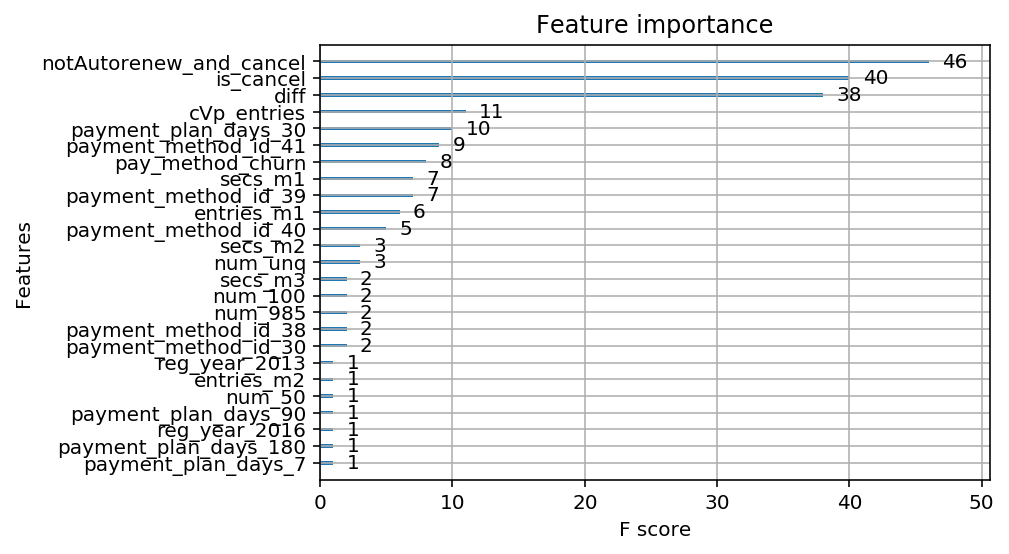

XGB Time = 421


array([0.06080386, 0.08252325, 0.06972957, ..., 0.00272648, 0.00319796,
       0.00319796], dtype=float32)

In [86]:
xgb_boost(feb_data_tweak,mar_data_tweak,1,0)

#### 5.1.2 Creating sets with tweaked features

In [79]:
apr_data_norm = apr_data_tweak.copy()
total_data_norm = total_data_tweak.copy()

scaler = MinMaxScaler()
scaler.fit(apr_data_norm.drop('msno',axis=1))
scaler.fit(total_data_norm.drop('msno',axis=1))

MinMaxScaler(copy=True, feature_range=(0, 1))

XG Boost does not require data normalization and thus the result got slightly worse.

### 5.2 Creating Submission Files
#### 5.2.1 Testing algorithms with standard data

##### XG Boost

In [23]:
#Prepare submission file XG Boost
y_pred_xgb = xgb_boost(total_data,apr_data,0,1)
my_submission = pd.DataFrame({'msno': apr_data.msno, 'is_churn': y_pred_xgb})
print(my_submission.head())
cols = my_submission.columns.tolist()
cols = cols[-1:] + cols[:-1]
my_submission = my_submission[cols]
print(my_submission.head())
print(my_submission.count())

my_submission.to_csv('submission_std.csv', index=False)
print('Done! :-)')

   is_churn                                          msno
0  0.013559  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1  0.007931  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2  0.046913  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3  0.013687  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4  0.022952  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=
                                           msno  is_churn
0  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=  0.013559
1  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=  0.007931
2  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=  0.046913
3  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=  0.013687
4  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=  0.022952
msno        907471
is_churn    907471
dtype: int64
Done! :-)


##### Ada Boost

In [ ]:
#Prepare submission file ADA
y_pred = ada_b(total_data,apr_data,1)
my_submission = pd.DataFrame({'msno': apr_data.msno, 'is_churn': y_pred})
print(my_submission.head())
cols = my_submission.columns.tolist()
cols = cols[-1:] + cols[:-1]
my_submission = my_submission[cols]
print(my_submission.head())
print(my_submission.count())

my_submission.to_csv('submission_ada.csv', index=False)
print('Done! :-)')

Model fitted!
   is_churn                                          msno
0  0.018822  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1  0.018822  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2  0.056930  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3  0.018822  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4  0.018822  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=
                                           msno  is_churn
0  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=  0.018822
1  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=  0.018822
2  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=  0.056930
3  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=  0.018822
4  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=  0.018822
msno        907471
is_churn    907471
dtype: int64
Done! :-)


##### Logistic Regression

In [66]:
#Prepare submission file Logistic Regression
y_pred = log_reg(total_data,apr_data,1)
my_submission = pd.DataFrame({'msno': apr_data.msno, 'is_churn': y_pred})
print(my_submission.head())
cols = my_submission.columns.tolist()
cols = cols[-1:] + cols[:-1]
my_submission = my_submission[cols]
print(my_submission.head())
print(my_submission.count())

my_submission.to_csv('submission_lr.csv', index=False)
print('Done! :-)')

/Users/maximekayser/miniconda3/envs/kkbox/lib/python3.6/site-packages/scipy/optimize/linesearch.py:461: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/maximekayser/miniconda3/envs/kkbox/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/maximekayser/miniconda3/envs/kkbox/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


   is_churn                                          msno
0         0  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1         0  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2         0  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3         0  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4         0  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=
                                           msno  is_churn
0  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=         0
1  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=         0
2  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=         0
3  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=         0
4  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=         0
msno        907471
is_churn    907471
dtype: int64
Done! :-)


##### Random Forrest

In [57]:
#Prepare submission file Random Forrest
y_pred = ran_for(total_data,apr_data,0,1)
my_submission = pd.DataFrame({'msno': apr_data.msno, 'is_churn': y_pred})
print(my_submission.head())
cols = my_submission.columns.tolist()
cols = cols[-1:] + cols[:-1]
my_submission = my_submission[cols]
print(my_submission.head())
print(my_submission.count())

my_submission.to_csv('submission_rf.csv', index=False)
print('Done! :-)')

   is_churn                                          msno
0      0.30  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1      0.20  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2      0.00  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3      0.00  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4      0.45  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=
                                           msno  is_churn
0  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=      0.30
1  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=      0.20
2  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=      0.00
3  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=      0.00
4  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=      0.45
msno        907471
is_churn    907471
dtype: int64
Done! :-)


#### 5.2.2 Testing XG Boost with only v1 / only v2 data

##### February (v1)

In [47]:
#Prepare submission file February
y_pred_xgb = xgb_boost(feb_data,apr_data,0,1)
my_submission = pd.DataFrame({'msno': apr_data.msno, 'is_churn': y_pred_xgb})
print(my_submission.head())
cols = my_submission.columns.tolist()
cols = cols[-1:] + cols[:-1]
my_submission = my_submission[cols]
print(my_submission.head())
print(my_submission.count())

my_submission.to_csv('submission_feb.csv', index=False)
print('Done! :-)')

   is_churn                                          msno
0  0.002781  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1  0.002713  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2  0.029647  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3  0.002781  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4  0.006030  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=
                                           msno  is_churn
0  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=  0.002781
1  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=  0.002713
2  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=  0.029647
3  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=  0.002781
4  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=  0.006030
msno        907471
is_churn    907471
dtype: int64
Done! :-)


##### March (v2)

In [46]:
#Prepare submission file March
y_pred_xgb = xgb_boost(mar_data,apr_data,0,1)
my_submission = pd.DataFrame({'msno': apr_data.msno, 'is_churn': y_pred_xgb})
print(my_submission.head())
cols = my_submission.columns.tolist()
cols = cols[-1:] + cols[:-1]
my_submission = my_submission[cols]
print(my_submission.head())
print(my_submission.count())

my_submission.to_csv('submission_mar.csv', index=False)
print('Done! :-)')

   is_churn                                          msno
0  0.031892  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1  0.016200  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2  0.071621  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3  0.031892  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4  0.061079  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=
                                           msno  is_churn
0  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=  0.031892
1  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=  0.016200
2  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=  0.071621
3  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=  0.031892
4  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=  0.061079
msno        907471
is_churn    907471
dtype: int64
Done! :-)


#### 5.2.3 XG Boost on the feature engineered dataset

In [82]:
#Prepare submission file TWEAK
y_pred_xgb = xgb_boost(total_data_tweak,apr_data_tweak,0,1)
my_submission = pd.DataFrame({'msno': apr_data_tweak.msno, 'is_churn': y_pred_xgb})
print(my_submission.head())
cols = my_submission.columns.tolist()
cols = cols[-1:] + cols[:-1]
my_submission = my_submission[cols]
print(my_submission.head())
print(my_submission.count())

my_submission.to_csv('submission_twk.csv', index=False)
print('Done! :-)')

   is_churn                                          msno
0  0.012652  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1  0.007016  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2  0.045187  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3  0.012652  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4  0.020476  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=
                                           msno  is_churn
0  4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=  0.012652
1  aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=  0.007016
2  rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=  0.045187
3  WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=  0.012652
4  aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=  0.020476
msno        907471
is_churn    907471
dtype: int64
Done! :-)
